# Basic setup

## preprocessing

In [2]:
#!pip install datasets transformers scikit-learn

In [4]:
import json
import pandas as pd
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

train_files = [
    "../data/eng-danc.json",
    "../data/eng-fina.json",
    "../data/eng-nava.json",
    "../data/eng-redh.json",
    "../data/eng-scan.json",
    "../data/eng-spec.json"
]
    
test_file = "../data/eng-houn.json"

In [6]:
def extract_words_and_sentiments(data):
    """
    Transforms a JSON data object into a list of [words, sentiment_labels] pairs.
    Sentiment is assigned to tokens based on the 'wids' from the concept data.
    Tokens not associated with any concept get a sentiment of 0.
    """
    transformed_data = []

    for sentence in data.get("sentences", []):
        words = sentence.get("words", [])
        concepts = sentence.get("concepts", [])

        word_list = [w["word"] for w in words]
        sentiment_list = ["NEUTRAL"] * len(words)  # initialize all sentiments as neutral (0)

        # map word id to index in words list
        wid_to_index = {w["wid"]: idx for idx, w in enumerate(words)}

        for concept in concepts:
            if "sentiment" in concept and "wids" in concept:
                sentiment = concept["sentiment"]

                if sentiment <= -20:
                    simple_sentiment = "NEGATIVE"
                elif sentiment >= 20:
                    simple_sentiment = "POSITIVE"
                else:
                    simple_sentiment = "NEUTRAL"

                for wid in concept["wids"]:
                    idx = wid_to_index.get(wid)
                    if idx is not None:
                        sentiment_list[idx] = simple_sentiment

        transformed_data.append([word_list, sentiment_list])

    return transformed_data


In [10]:
combined_train_list = []

for file in train_files:
    with open(file, "r") as f:
        data = json.load(f)
        transformed = extract_words_and_sentiments(data)
        combined_train_list.extend(transformed)

In [12]:
with open(test_file, "r") as f:
    test_data = json.load(f)
    
test_list = extract_words_and_sentiments(test_data)
combined_train_list[0]

[['The', 'Adventure', 'of', 'the', 'Dancing', 'Men'],
 ['NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL']]

In [14]:
df_train = pd.DataFrame(combined_train_list, columns=['tokens', 'sentiment_label'])
df_test = pd.DataFrame(test_list, columns=['tokens', 'sentiment_label'])
print(df_train.head())

                                              tokens  \
0            [The, Adventure, of, the, Dancing, Men]   
1  [Holmes, had, been, seated, for, some, hours, ...   
2  [His, head, was, sunk, upon, his, breast, ,, a...   
3  [", So, ,, Watson, ,, ", said, he, ,, suddenly...   
4           [I, gave, a, start, of, astonishment, .]   

                                     sentiment_label  
0  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
1  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
2  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
3  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
4  [NEUTRAL, NEUTRAL, NEUTRAL, NEGATIVE, NEUTRAL,...  


In [16]:
label_map = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}

df_train["sentiment_label"] = df_train["sentiment_label"].apply(
    lambda labels: [label_map[label] for label in labels]
)

def keep_only_positive_examples(df, min_positive=3):
    """
    Keeps examples with more than `min_positive` POSITIVE tokens.
    Sets all non-POSITIVE tokens to -100 so they don't contribute to loss.
    """
    filtered_rows = []

    for _, row in df.iterrows():
        labels = row["sentiment_label"]
        num_positive = labels.count(2)  # 2 = POSITIVE

        if num_positive > min_positive:
            new_labels = [2 if label == 2 else -100 for label in labels]
            filtered_rows.append({"tokens": row["tokens"], "sentiment_label": new_labels})

    return pd.DataFrame(filtered_rows)


df_train_positive_only = keep_only_positive_examples(df_train, min_positive=3)
print(f"Filtered down to {len(df_train_positive_only)} examples containing more than 3 POSITIVE tokens.")


df_test["sentiment_label"] = df_test["sentiment_label"].apply(
    lambda labels: [label_map[label] for label in labels]
)


Filtered down to 97 examples containing more than 3 POSITIVE tokens.


In [18]:
dataset_train = Dataset.from_pandas(df_train_positive_only)
dataset_test = Dataset.from_pandas(df_test)
print(dataset_train[3])
# Reduce test set to 10%
subset_size = int(0.1 * len(dataset_test))
dataset_test_small = dataset_test.select(range(subset_size))

{'tokens': ['"', 'You', 'gave', 'me', 'a', 'few', 'particulars', 'in', 'your', 'letter', ',', 'Mr.', 'Hilton', 'Cubitt', ',', 'but', 'I', 'should', 'be', 'very', 'much', 'obliged', 'if', 'you', 'would', 'kindly', 'go', 'over', 'it', 'all', 'again', 'for', 'the', 'benefit', 'of', 'my', 'friend', ',', 'Dr.', 'Watson', '.', '"'], 'sentiment_label': [-100, -100, 2, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2, -100, -100, -100, 2, -100, -100, -100, -100, -100, -100, -100, 2, -100, -100, -100, -100, -100, -100, -100, -100]}


In [22]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [23]:
label_all_tokens = True

In [24]:
def tokenize_and_align_labels(batch, label_all_tokens=True):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)

    all_labels = []

    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(batch["tokens"]))):
        word_labels = batch["sentiment_label"][i]
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(word_labels[word_idx])
            else:
                label_ids.append(word_labels[word_idx] if label_all_tokens else -100)

            previous_word_idx = word_idx

        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


In [28]:
tokenize_and_align_labels(dataset_train[:3])

{'input_ids': [[101, 1000, 1045, 11276, 2000, 2191, 2017, 3696, 1037, 3259, 2000, 2008, 3466, 1012, 1000, 102], [101, 1037, 3082, 3357, 2001, 2657, 2588, 1996, 5108, 1010, 1998, 2019, 7107, 2101, 2045, 3133, 1037, 4206, 1010, 25298, 2100, 1010, 4550, 1011, 27545, 2078, 10170, 1010, 3005, 3154, 2159, 1998, 13109, 10050, 2094, 6029, 2409, 1997, 1037, 2166, 2419, 2521, 2013, 1996, 9666, 2015, 1997, 6243, 2395, 1012, 102], [101, 2002, 2790, 2000, 3288, 1037, 1059, 25798, 1997, 2010, 2844, 1010, 4840, 1010, 25919, 1010, 2264, 1011, 3023, 2250, 2007, 2032, 2004, 2002, 3133, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [29]:
tokenized_training_dataset = dataset_train.map(tokenize_and_align_labels, batched=True)
tokenized_test_small = dataset_test_small.map(tokenize_and_align_labels, batched=True)
#tokenized_test_dataset = dataset_test.map(tokenize_and_align_labels, batched=True)

Map:   0%|                                        | 0/97 [00:00<?, ? examples/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████████████████████| 382/382 [00:00<00:00, 15236.93 examples/s]


In [32]:
tokenized_training_dataset[0]

{'tokens': ['"',
  'I',
  'ought',
  'to',
  'make',
  'you',
  'sign',
  'a',
  'paper',
  'to',
  'that',
  'effect',
  '.',
  '"'],
 'sentiment_label': [-100,
  -100,
  -100,
  -100,
  2,
  -100,
  -100,
  -100,
  -100,
  2,
  2,
  2,
  -100,
  -100],
 'input_ids': [101,
  1000,
  1045,
  11276,
  2000,
  2191,
  2017,
  3696,
  1037,
  3259,
  2000,
  2008,
  3466,
  1012,
  1000,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100,
  -100,
  -100,
  -100,
  -100,
  2,
  -100,
  -100,
  -100,
  -100,
  2,
  2,
  2,
  -100,
  -100,
  -100]}

## model training

In [31]:
#!pip install evaluate
#!pip install seqeval
#!pip install torch
#!pip install "accelerate>=0.26.0"

In [34]:
import evaluate
import numpy as np
model_checkpoint = "bert-base-uncased"
task = "sentiment_analysis"
batch_size = 16

In [36]:
from transformers import set_seed

#put your seed
SEED = 123
set_seed(SEED)
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

In [38]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load("seqeval")
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
label_list = ["NEGATIVE", "NEUTRAL", "POSITIVE"]

In [42]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [44]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_test_small, #write test
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2230/913721409.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [46]:
trainer.train()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.613556,0.014105,0.048030,0.021806,0.707165
2,No log,0.613556,0.014105,0.048030,0.021806,0.707165
3,No log,0.613556,0.014105,0.048030,0.021806,0.707165


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maja/Documents/VU/thesis/venv

TrainOutput(global_step=21, training_loss=0.0, metrics={'train_runtime': 31.4286, 'train_samples_per_second': 9.259, 'train_steps_per_second': 0.668, 'total_flos': 13118424085740.0, 'train_loss': 0.0, 'epoch': 3.0})

In [49]:
trainer.save_model('BERT_negative_model')
trainer.tokenizer.save_pretrained('BERT_negative_model')

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('BERT_negative_model/tokenizer_config.json',
 'BERT_negative_model/special_tokens_map.json',
 'BERT_negative_model/vocab.txt',
 'BERT_negative_model/added_tokens.json',
 'BERT_negative_model/tokenizer.json')

In [50]:
model = AutoModelForTokenClassification.from_pretrained("BERT_negative_model")
tokenizer = AutoTokenizer.from_pretrained("BERT_negative_model")

In [53]:
trainer.evaluate()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6135562658309937,
 'eval_precision': 0.014104882459312839,
 'eval_recall': 0.0480295566502463,
 'eval_f1': 0.02180598266703942,
 'eval_accuracy': 0.7071651090342679,
 'eval_runtime': 3.5027,
 'eval_samples_per_second': 109.06,
 'eval_steps_per_second': 6.852,
 'epoch': 3.0}

In [55]:
predictions, labels, _ = trainer.predict(tokenized_test_small) #data set
predictions = np.argmax(predictions, axis=2)

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEUTRAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWar

## model evaluation

In [57]:
#!pip install matplotlib

In [58]:
def map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_dataset, output_file_path):
    import csv
    import numpy as np

    with open(output_file_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(['word', 'prediction', 'gold_label'])

        new_tokens = []
        new_labels = []
        new_predictions = []

        for idx, (prediction, label) in enumerate(zip(predictions, labels)):
            tokens = tokenized_dataset["tokens"][idx]
            input_ids = tokenized_dataset["input_ids"][idx]

            # Re-tokenize to get word_ids
            tokenized = tokenizer(tokens, truncation=True, is_split_into_words=True, return_tensors="pt")
            word_ids = tokenized.word_ids(batch_index=0)

            word_predictions = {}
            word_labels = {}

            for token_idx, word_idx in enumerate(word_ids):
                if word_idx is None:
                    continue  # Skip special tokens

                if word_idx not in word_predictions:
                    word_predictions[word_idx] = []
                word_predictions[word_idx].append(prediction[token_idx])

                if label[token_idx] != -100:
                    word_labels[word_idx] = label[token_idx]

            for word_idx in sorted(word_predictions.keys()):
                pred_id = np.argmax(np.bincount(word_predictions[word_idx]))
                predicted_label = label_list[pred_id]

                gold_label = label_list[word_labels[word_idx]] if word_idx in word_labels else "O"

                word_tokens = [
                    tokenizer.convert_ids_to_tokens(input_ids[i])
                    for i, w_idx in enumerate(word_ids) if w_idx == word_idx
                ]
                word = tokenizer.convert_tokens_to_string(word_tokens).strip()

                new_tokens.append(word)
                new_predictions.append(predicted_label)
                new_labels.append(gold_label)

                writer.writerow([word, predicted_label, gold_label])

    print(f"Results saved to {output_file_path}")
    return new_tokens, new_labels, new_predictions


In [62]:
output_file = "negative_BERT.csv"
new_tokens, new_labels, new_predictions = map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_test_small, output_file)

Results saved to negative_BERT.csv


In [64]:
print(new_tokens[:30])
print(new_labels[:30])
print(new_predictions[:30])

['the', 'hound', 'of', 'the', 'baskervilles', 'chapter', '1', ':', 'mr', 'sherlock', 'holmes', 'mr', 'sherlock', 'holmes', ',', 'who', 'was', 'usually', 'very', 'late', 'in', 'the', 'mornings', ',', 'save', 'upon', 'those', 'not', 'infrequent', 'occasions']
['NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL']
['NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEGATIVE', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEGATIVE', 'NEGATIVE', 'NEUTRAL']


Accuracy: 0.7126923076923077
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE     0.0114    0.1860    0.0215       129
     NEUTRAL     0.9717    0.7310    0.8343      7572
    POSITIVE     0.0000    0.0000    0.0000        99

    accuracy                         0.7127      7800
   macro avg     0.3277    0.3057    0.2853      7800
weighted avg     0.9435    0.7127    0.8103      7800



/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

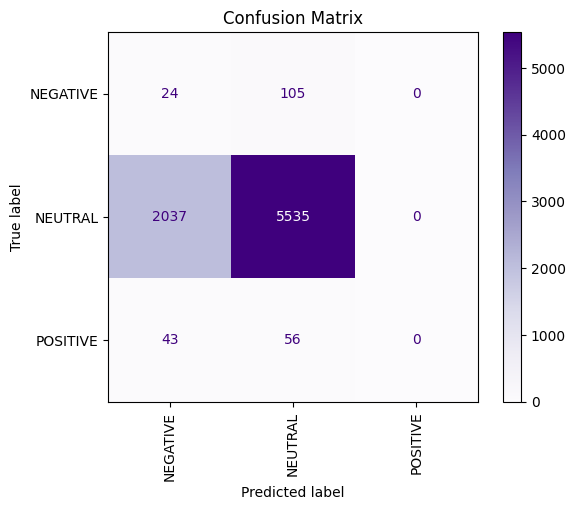

In [66]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

def evaluate_predictions(predictions, gold_labels, label_list):
    """
    Evaluate predictions against gold labels and print metrics.
    """
    predictions_flat = [label_list.index(label) for label in predictions]
    gold_labels_flat = [label_list.index(label) for label in gold_labels]

    accuracy = accuracy_score(gold_labels_flat, predictions_flat)
    report = classification_report(gold_labels_flat, predictions_flat, target_names=label_list, digits=4)

    cm = confusion_matrix(gold_labels_flat, predictions_flat, labels=list(range(len(label_list))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
   
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

evaluate_predictions(new_predictions, new_labels, label_list)
